In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment
from util.random import smooth_random_loop_fourier_coef, fourierGP_2D_lerp
from util.logger import EventTracker
from util.plot_tools import remove_axes
import pygmsh as pg

## Domain
Start by defining the domain. A channel flow with random inclusions.


### Notes

BETTER INITIAL GUESS DOES BIG DIFFs


In [2]:
with pg.geo.Geometry() as geom: 
    geom.add_rectangle(0, 1, 0, 1, 0, 1)

: 

: 

In [3]:
R = 1
r = 0.3

N_blobs = 10
thetas = np.linspace(0, 2*np.pi, N_blobs+1)[:-1]
pos_blob = (R + r) / 2
r_blob = (R - r) / 5
pos = lambda theta: np.cos(N_blobs/2 * theta) * ((R - r)*(0.3) - r_blob) + pos_blob
centers = [dl.Point(pos(theta)*np.cos(theta), pos(theta)*np.sin(theta)) for theta in thetas]


#### ROUGHNESS FUNCTION
dom = [[-R, R], [-R, R]]
lerp, x, y = fourierGP_2D_lerp(kmax_x=1001, kmax_y=1001, L=0.04, LAmp=0., eps=0.004, epsAmp=0.02, dom=dom)

class CircleDomain(dl.SubDomain):
    def __init__(self, x, y, r, tol, bdry=True):
        self.x = x
        self.y = y
        self.r = r
        self.tol = tol
        self.bdry = bdry
        super(CircleDomain, self).__init__()
        
    def inside(self, x, on_boundary):
        if self.bdry:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol) and on_boundary)
        else:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol))
        
    def rough_inset(self, roughness_field, N):
        t = np.linspace(0, 2*np.pi, N+1)[:-1]
        cos_t = np.cos(t)
        sin_t = np.sin(t)
        x = self.x + self.r*cos_t
        y = self.y + self.r*sin_t
        #r = self.r * 0.90# -roughness_field(x, y) #0.02*(1 + np.sin(100 * t)))#
        r = self.r  -roughness_field(x, y) #0.02*(1 + np.sin(100 * t)))#
        return np.hstack([self.x + (r * cos_t)[:, None], self.y + (r * sin_t)[:, None]])
         

class UnionDomain(dl.SubDomain):
    def __init__(self, domains):
        self.domains = domains
        super(UnionDomain, self).__init__()
    
    def inside(self, x, on_boundary):
        return bool(any([domain.inside(x, on_boundary) for domain in self.domains]))

    def rough_inset(self, roughness_field, N):
        return np.vstack([domain.rough_inset(roughness_field, N) for domain in self.domains])


class Floor(dl.SubDomain):
    def inside(self, x, on_boundary):
        return bool(False) #bool(dl.near((x[0]-c.x())**2 + (x[1]-c.y())**2, r_blob**2))


def circle(x, y, r, N):
    #t = np.linspace(0, 2*np.pi, N+1)[:-1]
    #return ms.Polygon([dl.Point(x + r*np.cos(ti), y + r*np.sin(ti)) for ti in t])
    return ms.Circle(dl.Point(x, y), r)#), N)

### SUBDOMAINS ###
TOL = 0.03
outer = CircleDomain(0, 0, R, TOL, False)
inner = CircleDomain(0, 0, r, TOL, False)
inclusions = [CircleDomain(centers[i].x(), centers[i].y(), r_blob, TOL, False) for i in range(N_blobs)]
inclusion_union = UnionDomain(inclusions)
roughnesses = [inclusion.rough_inset(lerp, 800) for inclusion in inclusions]
roughness = inclusion_union.rough_inset(lerp, 800)

outer_bdry = CircleDomain(0, 0, R, TOL, True)
inner_bdry = CircleDomain(0, 0, r, TOL, True)
inclusion_boundaries = [CircleDomain(centers[i].x(), centers[i].y(), r_blob, TOL, True) for i in range(N_blobs)]


#### MESH ####
domain = circle(0,0,R,400) - circle(0, 0, r, 200)
for i in range(N_blobs):
    #poly = ms.Circle(centers[i], r_blob)
    poly = circle(centers[i].x(), centers[i].y(), r_blob, 200)
    domain = domain - poly
mesh = ms.generate_mesh(domain, resolution=40)


#mesh_func = dl.MeshFunction("bool", mesh, mesh.topology().dim()-1, False)
#outer.mark(mesh_func, True)
#inner.mark(mesh_func, True)
#inclusion_union.mark(mesh_func, True)
#for inclusion in inclusions:
 #   inclusion.mark(mesh_func, True)
#mesh = dl.refine(mesh, mesh_func)

#plt.figure(figsize=(20,20))
#dl.plot(mesh)
#plt.plot(roughness[:,0], roughness[:,1], 'r')
#X, Y = np.meshgrid(x, y)
#plt.pcolormesh(X, Y, lerp.Z, cmap='gray')

In [4]:
# Define the function spaces
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1)
U, P = W.split() 
Ux, Uy = U.split()

# Boundary Conditions
bcu_inner = dl.DirichletBC(U, dl.Expression((f'x[1]/{r}', f'-x[0]/{r}'), degree=2), inner_bdry)
bcu_outer = dl.DirichletBC(U, dl.Expression((f'x[1]/{R}', f'-x[0]/{R}'), degree=2), outer_bdry)
bcu_inclusions = [dl.DirichletBC(U, dl.Constant((0., 0.)), inclusion) for inclusion in inclusion_boundaries]
#bcu_inclusion = dl.DirichletBC(U, dl.Constant((0,0)), inclusion_union)

In [5]:
bcu = [bcu_outer, bcu_inner]
data = StokesData.from_mesh(mesh, inclusion_union, roughness, W, bcu)


def interp(x, a):
    amean = -np.mean(a)
    print(amean)
    #return lambda x, y: amean #basis(np.array([x]))[0]
    return micros_to_macro(x, [-s for s in a], scale=0.2)
    #return lambda x,y: amean#: basis(np.array([x]))[0]

mac = StokesMacProb(data, interp=interp, alpha0=lambda x,y: 0.01, lam=1e3)
mac_solver = MacroSolver()

#plt.figure(figsize=(20,20))
#dl.plot(mesh)
#plt.plot(roughness[:,0], roughness[:,1], 'r')
#plt.xlim([-0.75, -0.25])
#plt.ylim([-0.25, 0.25])

projection_op = lambda *args: macro_to_micro(*args, N=7)
#np.array([-0.55,0.2])


sub_pts = roughness[50::len(roughness)//50, :]
#plt.scatter(sub_pts[:,0], sub_pts[:,1])
mics = [StokesMicProb(data, xt, projection_op=projection_op, debug=False, width=0.03, height=0.02, corner_w=0.005, pad=0.05) for xt in sub_pts]
#mic_solvers = [MicroSolver(mic , tol=1e-6) for mic in mics]

hmm_prob = StokesHMMProblem(mac, mics, data)

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 497 nodes for 249 points.


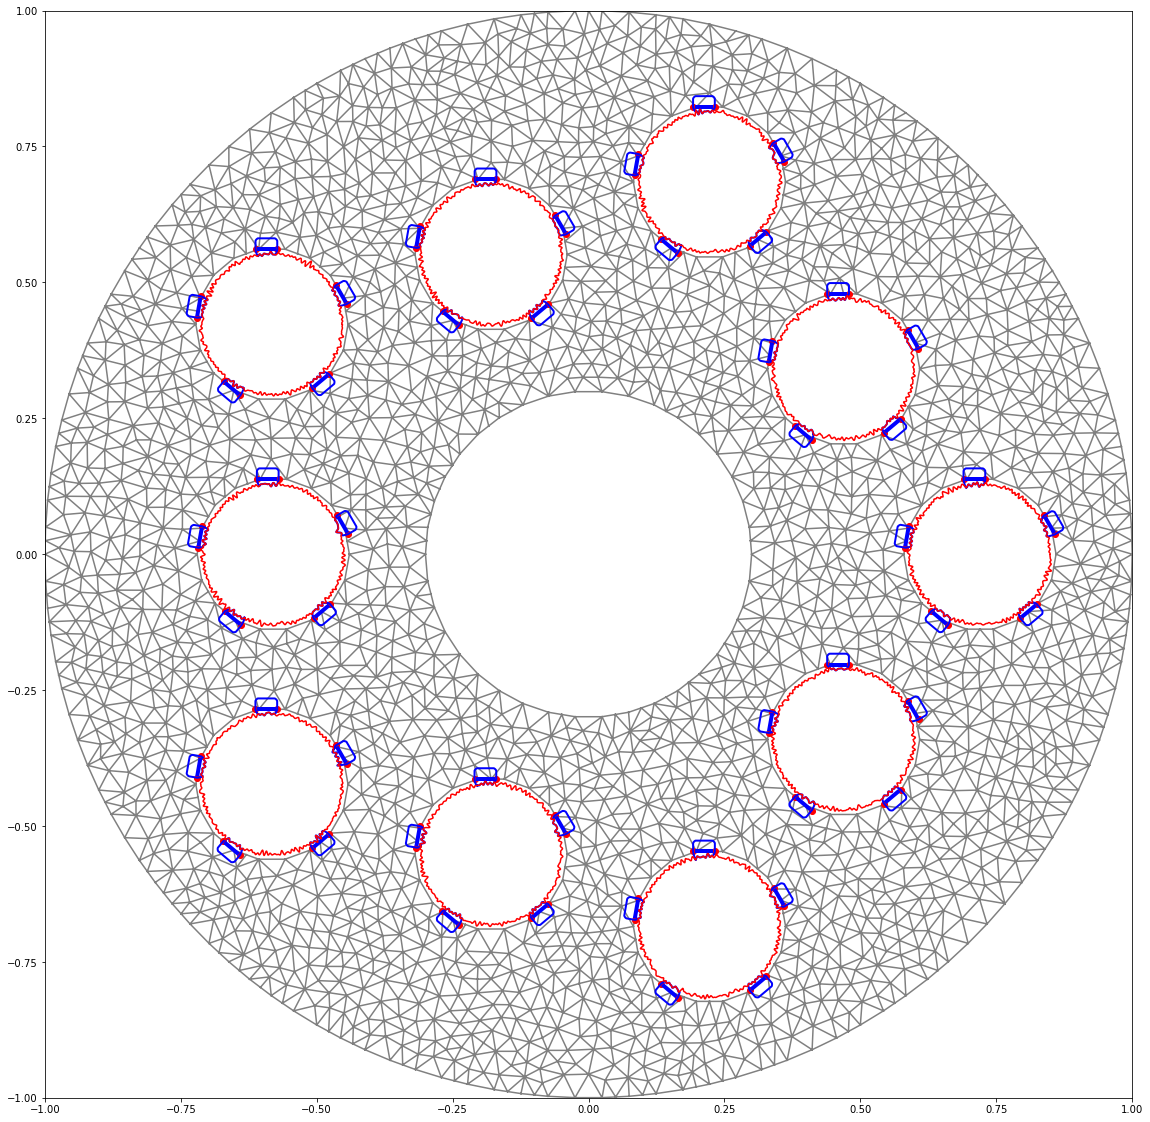

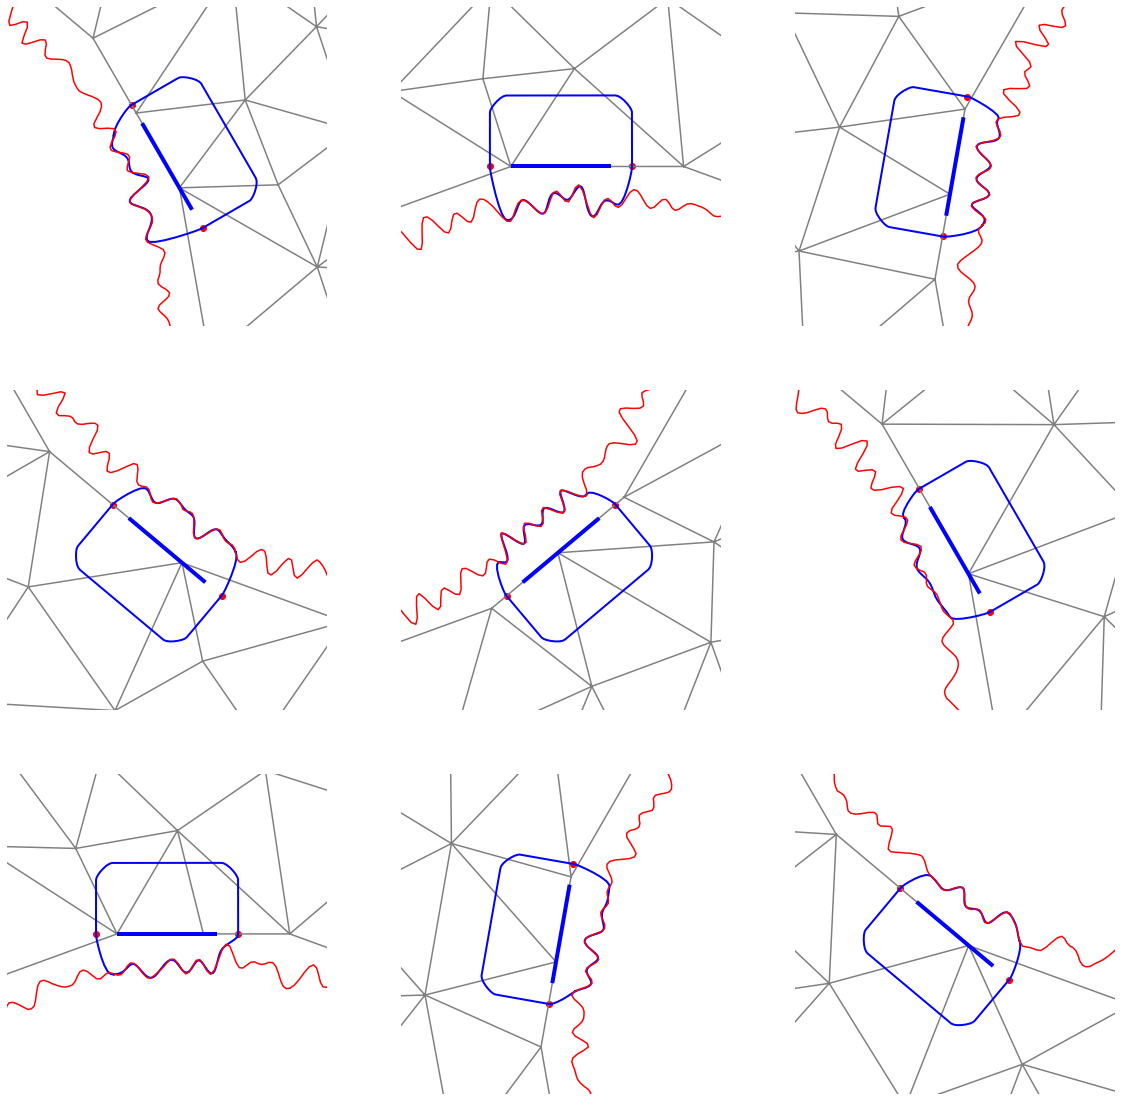

In [6]:
plt.figure(figsize=(20,20))
data.plot(plt.gca())
#hmm_prob.plot(plt.gca(), color='black')
for mic in mics:
    mic.plot(plt.gca(), color='blue', linewidth=2)
for rough in roughnesses:
    plt.plot(rough[:,0], rough[:,1], 'r')
plt.xlim(*dom[0])
plt.ylim(*dom[1])

plt.figure(figsize=(20,20))
n = 3#int(np.floor(np.sqrt(len(mics))))
for i in range(n*n):
    mic = mics[i]
    plt.subplot(n, n, i+1)
    mic.plot(plt.gca(), color='blue', linewidth=2)
    dl.plot(mesh)
    for rough in roughnesses:
        plt.plot(rough[:,0], rough[:,1], 'r')
    #pt.plot(roughness[:,0], roughness[:,1], 'r')
    remove_axes(plt.gca())
    plt.xlim([mic.center[0] - 3*mic.width/2, mic.center[0] + 3*mic.width/2])
    plt.ylim([mic.center[1] - 3*mic.width/2, mic.center[1] + 3*mic.width/2])
    



In [6]:
logger = EventTracker()

logger.start_event("Precompute Micros")
mic_solvers = [MicroSolver(mic , tol=1e-6) for mic in mics]
logger.end_event("Precompute Micros")

hmm_solver = IterativeHMMSolver(mac_solver, mic_solvers)
guess = mac_solver.solve(mac, verbose=True)
macro_sol, micro_sols = hmm_solver.solve(hmm_prob, macro_guess=guess, maxiter=6, verbose=True, logger =logger)

Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 8787 nodes for 4394 points.
0.004924193158775162ver, removing - sign
Solving linear variational problem.
0.004924193158775162
0.005140005707779901ver, removing - sign
Solving linear variational problem.
0.005140005707779901
0.005767315693264616ver, removing - sign
Solving linear variational problem.
0.005767315693264616
0.005202996863208815ver, removing - sign
Solving linear variational problem.
0.005202996863208815
0.0039999334656374156er, removing - sign
Solving linear variational problem.
0.0039999334656374156
0.004786182265121166ver, removing - sign
Solving linear variational problem.
0.004786182265121166


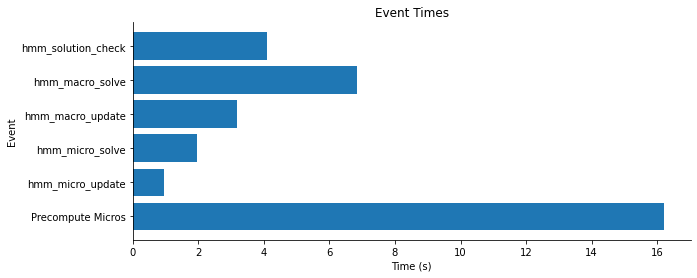

In [7]:

plt.figure(figsize=(10,4))
logger.barplot_logs(plt.gca())

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


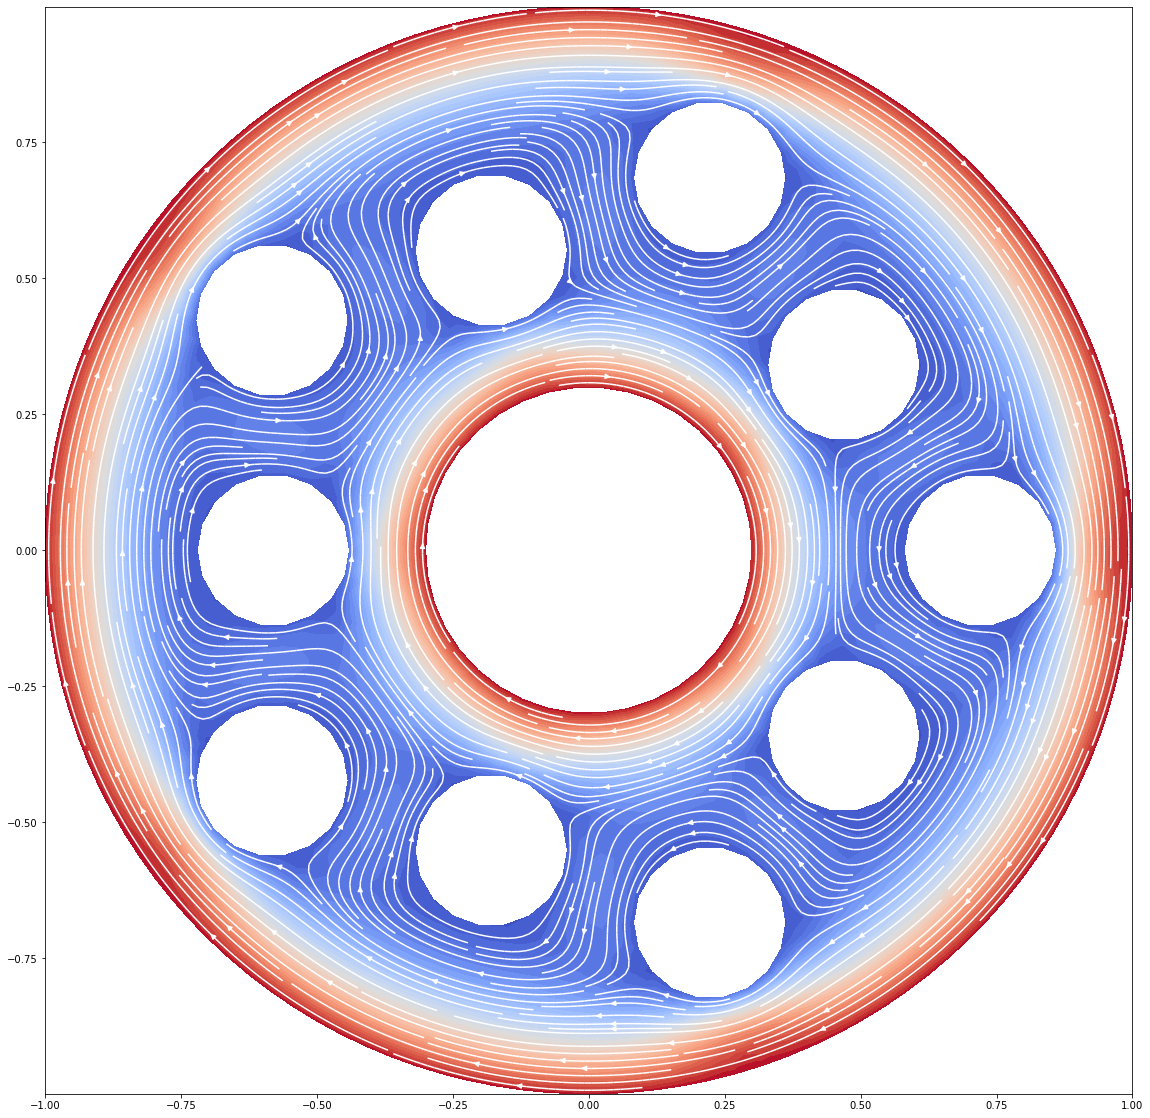

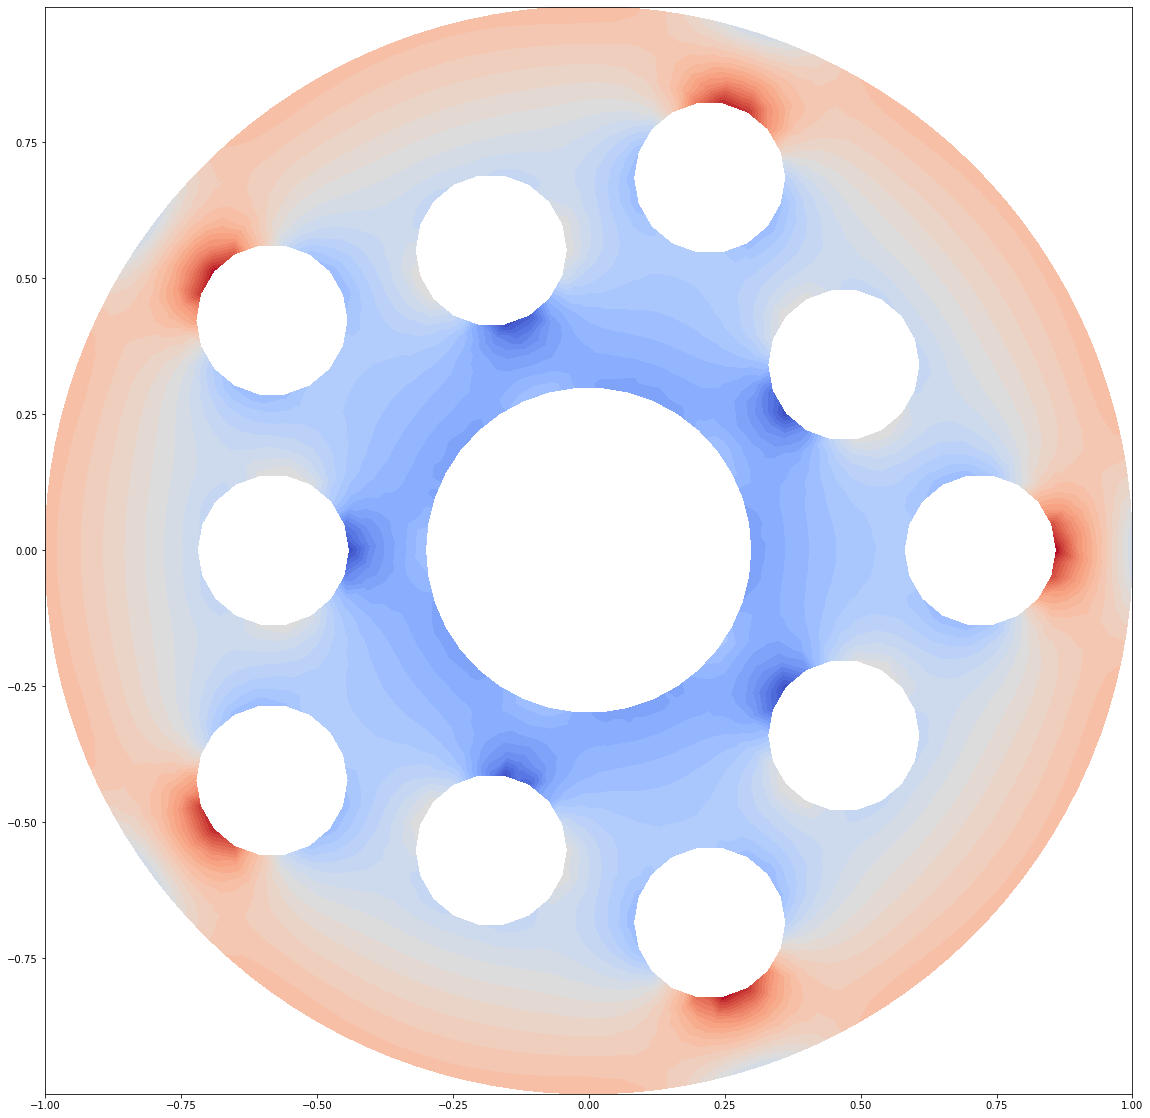

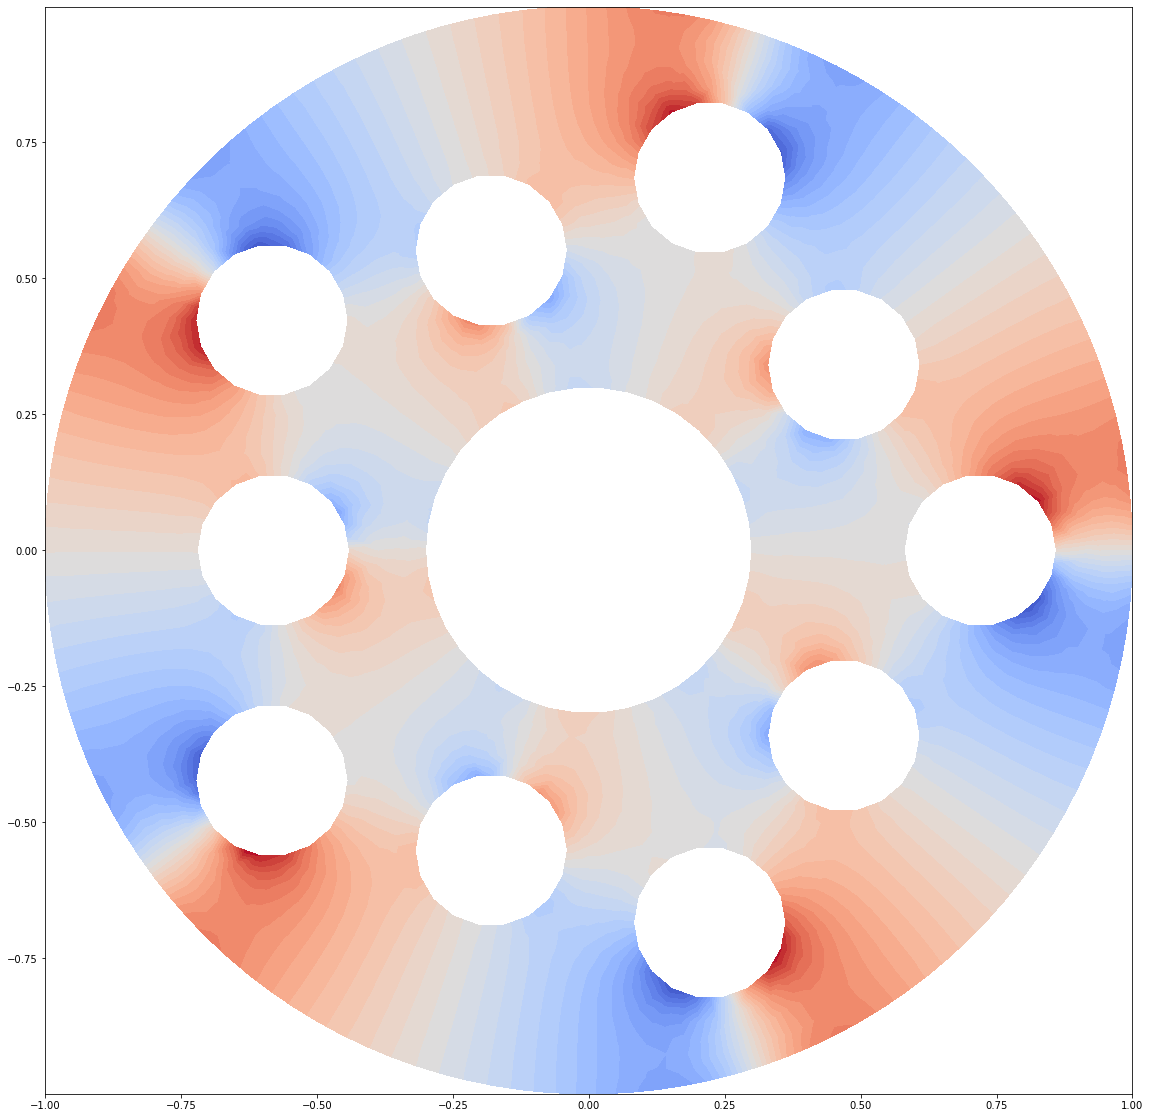

In [9]:
#sol.u.vector()[:] = np.where(np.isnan(sol.u.vector()[:]), 0, sol.u.vector()[:])
#sol.v.vector()[:] = np.where(np.isnan(sol.v.vector()[:]), 0, sol.v.vector()[:])
sol = macro_sol
abs_u = (sol.u * sol.u + sol.v * sol.v) ** 0.5
w = sol.grad_u[1] - sol.grad_v[0]
#print(sol.u.vector()[:])

plt.figure(figsize=(20,20))
dl.plot(abs_u, cmap='coolwarm')#, vmin=0., vmax=1.)
sol.plot_stream(plt.gca(), dom=mesh, bbox=[[-1.,1.], [-1., 1.]], npts=300, color='white', density=5)

plt.figure(figsize=(20,20))
dl.plot(w, cmap='coolwarm')#, vmin=-10., vmax=10.)

plt.figure(figsize=(20,20))
dl.plot(sol.p, cmap='coolwarm')#, vmin=-20., vmax=20.)